# Generation of the Hopf Fibration with PYNQ
## Using AXI-Lite

#### Created by Group A : Finlay Harris, Morgan McFarlane, James Petrie

Purpose: <br>Submission for University of Strathclyde: EE315 Further VHDL and FPGA Design <br>

Aim:<br> To generate an artist representation of the Hopf Fibration by passing off computationally challenging sections to the PL section of the SoC to process sections in parallel. The Hopf Fibration generated using the PL should be the same as the one generated in only software <br>

Decription: <br> This notebook contains the software and hardware implementation of an artist representation of the Hopf Fibration using a trigonmetric approach. The hardware approach makes use of AXI-Lite rather than AXI-Stream. The two methods are timed to compare which method is faster. <br>

### What is the Hopf Fibration?

The Hopf fibration is a fascinating and fundamental concept in the field of topology, a branch of mathematics. It was discovered by Heinz Hopf in 1931. This fibration is an example of a map from one sphere to another sphere of lower dimension, specifically from a 3-dimensional sphere \( S^3 \) to a 2-dimensional sphere \( S^2 \).

The Hopf fibration is significant because it is one of the first discovered examples of a fiber bundle where the total space and the base space are both spheres but of different dimensions. It illustrates a deep geometric and topological structure, showing that \( S^3 \) can be thought of as a union of circles (1-dimensional spheres), each of which is parameterized by points on \( S^2 \).

This concept has profound implications in various fields of mathematics and physics, particularly in the study of complex numbers and quaternionic structures. The fibers in the Hopf fibration are circles, and each fiber is linked with every other fiber exactly once, demonstrating an elegant intertwining structure.

![Hopf Fibration Visualization](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Hopf_Fibration.png/1200px-Hopf_Fibration.png)




### Include Relevant Libraries:
- **numpy** - To handle arrays in python.
- **matplotlib** and **mpl_toolkits.mplot3d** - For plotting 3D visuals.
- **PYNQ overlay** and **allocate** - To enable interaction with programmable logic (PL) on PYNQ-enabled devices.
- **time** - To record the elapsed time of processes.


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pynq import allocate
from pynq import Overlay
import time

### Generating Inputs for Software & Hardware

The inputs to the system are three angles, each with a specific range and purpose:

1. **Alpha**: This angle typically represents a rotation around the vertical axis. In the context of this system, it ranges from $ 0$ to  $4pi$  radians, allowing for two full rotations, which could be necessary for certain types of symmetry or periodic functions.

2. **Phi**: Often denoted as the azimuthal angle in spherical coordinates, it represents a rotation around the horizontal axis. For our system,  $phi $ spans from $ 0 $ to $pi $ radians, corresponding to a semi-circle from one pole to the other.

3. **Theta**: This is the polar or inclination angle, measuring the angle from the zenith direction. In our setup, $theta$  varies between $ 0 $ and 2$pi $ radians, which covers a complete rotation around the axis, similar to latitude in geographic coordinates.

Each angle is sampled into 50 points, resulting in a set of 50 unique values for $alpha$, $phi$ , and $theta$, which are used as inputs for the system to define points on a sphere in three-dimensional space or to control the orientation of a physical device in the case of hardware applications.



In [2]:
# Function to generate an array of angle samples based off the range given in the parameters
# Parameters: start- start of range, end - end of range, num_points - number of elements in array
def generate_angle_array(start, end, num_points):
    return np.linspace(start, end, num=num_points)

In [3]:
# Define the angles
num_points = 50
alpha_array = generate_angle_array(0, 4*np.pi, num_points)
phi_array = generate_angle_array(0, np.pi, num_points)
theta_array = generate_angle_array(0, 2*np.pi, num_points)

<IPython.core.display.Javascript object>


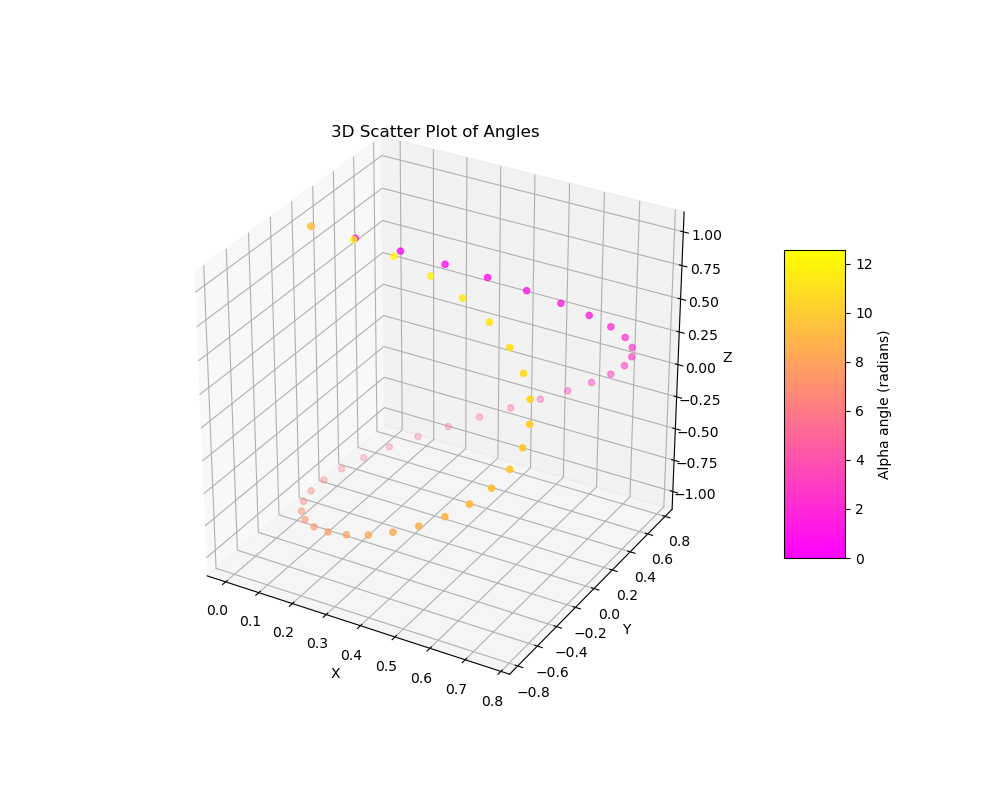

In [4]:
# Generate a 3D Plot to visualise angles generated
##################################################

# Transform spherical coordinates to Cartesian coordinates for the plot
x = np.sin(theta_array) * np.cos(phi_array)
y = np.sin(theta_array) * np.sin(phi_array)
z = np.cos(theta_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=alpha_array, cmap='spring')

# Colorbar to show the alpha values
colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
colorbar.set_label('Alpha angle (radians)')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Scatter Plot of Angles')

# Show the plot
plt.show()

### Software Implementation
##### Generate the Hopf Map:

In [5]:
# Function to calculate the Hopf Map
####################################

def hopf_map(alpha, phi, theta):
    """
    Parametrise the 3-sphere in 4D space using the Hopf fibration.
    
    :param alpha: angle ranging from 0 to 4π
    :param phi: angle ranging from 0 to 2π
    :param theta: angle ranging from 0 to 2π
    :return: tuple (X0, X1, X2, X3) representing a point in 4D space
    """
   

    X0 = np.cos((alpha + phi) / 2) * np.sin(theta / 2)
    X1 = np.sin((alpha + phi) / 2) * np.sin(theta / 2)
    X2 = np.cos((alpha - phi) / 2) * np.cos(theta / 2)
    X3 = np.sin((alpha - phi) / 2) * np.cos(theta / 2)
    
    return X0, X1, X2, X3



##### Perform Stereographic Projection:

In [6]:
# Function to perform stereographic projection (drop a dimension)
#################################################################

def stereographic_projection(X0, X1, X2, X3):
    """
    Parametrise the 4D Coordinates to 3D.
    
    :param X0,X1,X2,X3: 4D Coordinates
    :return: x,y,z representing a point in 3D space
    """

    # Avoid division by zero in case X3 is 1
    denom = 1 - X3
    # Use np.where to handle near-zero values
    denom = np.where(np.isclose(denom, 0), np.finfo(float).eps, denom)
    
    x = X0 / denom
    y = X1 / denom
    z = X2 / denom
    
    return x, y, z



##### Generating the Software Results:

In [7]:
# Function to plot defined number of Fibres on the Hopf Fibration
#################################################################

def visualise_hopf_fibration(num_fibers=200, num_points_per_fiber=1000):
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Colour map
    colours = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))
    
    start = time.time()

    for i in range(num_fibers):
        phi = 2 * np.pi * (i / num_fibers)  # Constant for each fiber
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)  # Varies along each fiber 
        
        # Calculate 4D Coordinates
        X0, X1, X2, X3 = hopf_map(alpha, phi, theta)
        # Drop a dimension
        x, y, z = stereographic_projection(X0, X1, X2, X3)
        
        # Find the maximum absolute coordinate from x, y, z
        max_coord = np.max([np.abs(x).max(), np.abs(y).max(), np.abs(z).max()])

        # Normalize the coordinates so that all are within the range [-1, 1]
        x_normalised = x / max_coord
        y_normalised = y / max_coord
        z_normalised = z / max_coord
        ax.plot(x_normalised, y_normalised, z_normalised, color=colours[i], alpha=0.6)
        
    elapsed_time = time.time() - start
    print("Total Time to calcualte 4D Coordinates & perform Stereographic Projection = ", elapsed_time, " seconds" )

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Hopf Fibration Visualisation')
    plt.show()

<IPython.core.display.Javascript object>


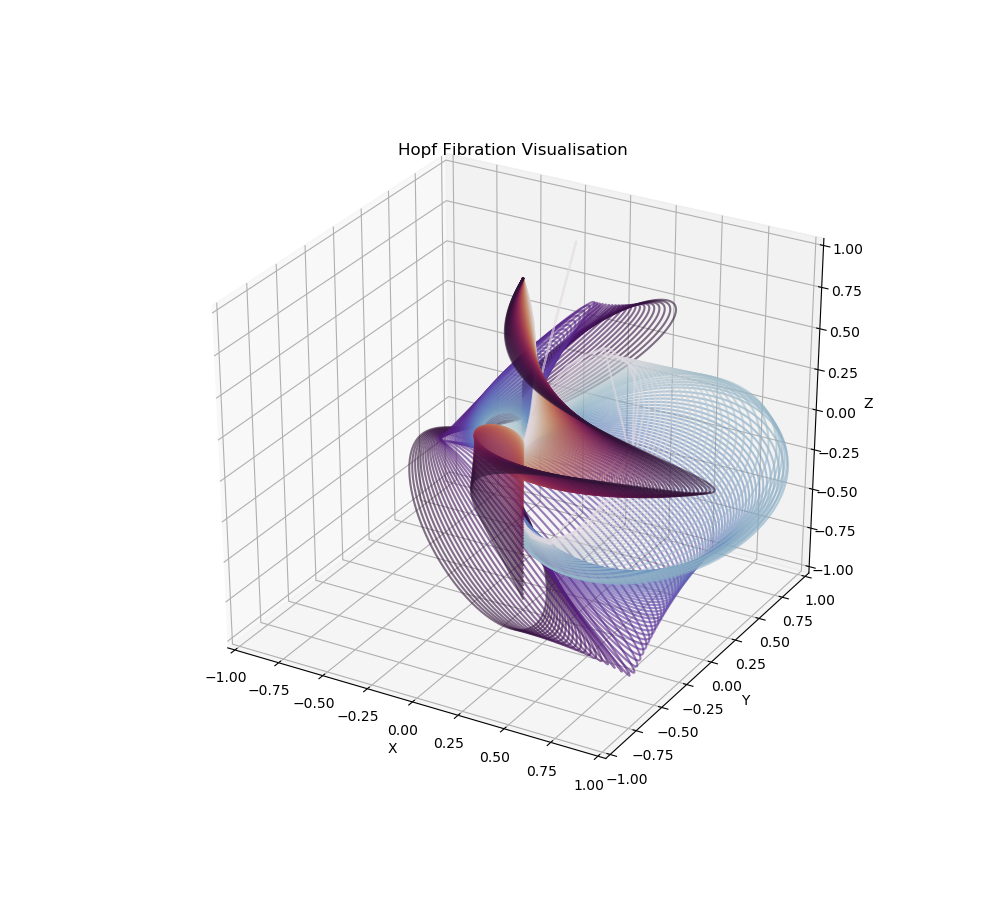

Total Time to calcualte 4D Coordinates & perform Stereographic Projection =  4.2901201248168945  seconds
TotalTime to generate =  4.7136499881744385  seconds


In [8]:
start = time.time()

# Generate and visualise the Hopf fibration
visualise_hopf_fibration()

elapsed_time = time.time() - start
print("TotalTime to generate = ", elapsed_time, " seconds" )

### Hardware implementation:
##### Import Hopf Fibration hardware:
The hardware was created using model composer and exported to Vivado to generate a bitstream and hardware handoff file.

In [9]:
ol = Overlay("FINAL_HOPF.bit")
ol?
hopf = ol.axi_lite_hopf_0

##### Hardware driver:

In [10]:
# Function that defines the Hardware Driver
###########################################

def get4DCoords(theta_bin, alpha_bin, phi_bin):
    # Ensure the values are integers
    theta_bin = int(theta_bin)
    alpha_bin = int(alpha_bin)
    phi_bin = int(phi_bin)

    # Write to FPGA
    hopf.write(0x08, theta_bin)
    hopf.write(0x04, alpha_bin)
    hopf.write(0x00, phi_bin)

    # Read from FPGA
    x0_bin = hopf.read(0x0C)
    x1_bin = hopf.read(0x10)
    x2_bin = hopf.read(0x14)
    x3_bin = hopf.read(0x18)

    return x0_bin, x1_bin, x2_bin, x3_bin


##### Data Conversion Funtions:
Communication between software and hardware transfers at 32 bits at a time; to allow for correct range and precision, the IP is expecting an input of a fixed point, signed 32 bit number with 0 fractional bits. <br> The float_to_binary function shows this conversion. 

When recieved, this fixed point formatting needs to be scaled back to a float to enable further calculations.

In [11]:
def float_to_binary(val):
    """
    Convert a floating-point number to a 32-bit signed fixed-point number with specific fractional bits.
    This version is updated to handle arrays and single values uniformly and ensures integer output.
    """
    if isinstance(val, np.ndarray):
        output = np.floor(val * (1 << 18)).astype(np.int32)  # Adjust shift for the number of fractional bits your FPGA expects
    else:
        output = int(val * (1 << 18))
    return output & ((1 << 32) - 1)


def binary_to_float(val):
    """
    Convert a 24-bit signed fixed-point number to a floating-point number.
    The fixed-point number has 18 fractional bits and is stored in the least significant bits of a 32-bit variable.

    :param val: 24-bit signed fixed-point number represented in a 32-bit integer.
    :return: Floating-point number.
    """
    # Mask the relevant 24 bits
    val &= (1 << 24) - 1

    # Check if the sign bit is set (most significant bit of 24-bit number)
    if val & (1 << 23):  
        # Apply two's complement to get the negative value
        val = val - (1 << 24)

    # Divide by 2^18 to convert the fixed-point number to float
    # The denominator is 2^18 because there are 18 fractional bits
    return val / float(1 << 18)

##### Generate results from hardware:
###### Generate the Hopf Map:

In [12]:
# Function to find the Hopf Map using the output from the PL
############################################################

def hopf_map2(alpha_array, phi, theta_array):
    """
    Calculate 4D coordinates using the Hopf fibration with PL computation.

    :param alpha_array: Array of alpha angles.
    :param phi: Single value of phi for the entire set of computations.
    :param theta_array: Array of theta angles.
    :return: Four NumPy arrays representing the points in 4D space.
    """
    # Convert angles to binary before passing to the FPGA
    theta_bin_array = float_to_binary(theta_array)
    alpha_bin_array = float_to_binary(alpha_array)
    phi_bin = float_to_binary(phi)  # Handle phi as a scalar

    # Simulating the FPGA computation for demonstration purposes
    # Normally, you would send these to the FPGA and get results back
    x0_list, x1_list, x2_list, x3_list = [], [], [], []
    for theta_bin, alpha_bin in zip(theta_bin_array, alpha_bin_array):
        # Assume a placeholder function `get4DCoords` handles these binaries
        x0_bin, x1_bin, x2_bin, x3_bin = get4DCoords(theta_bin, alpha_bin, phi_bin)
        x0_list.append(binary_to_float(x0_bin))
        x1_list.append(binary_to_float(x1_bin))
        x2_list.append(binary_to_float(x2_bin))
        x3_list.append(binary_to_float(x3_bin))

    return np.array(x0_list), np.array(x1_list), np.array(x2_list), np.array(x3_list)



In [13]:
# Function to visualise and generate the Hopf Fibration using Hardware
######################################################################

def visualise_hopf_fibration2(num_fibers=200, num_points_per_fiber=1000):
    # Create a new figure for 3D plotting
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define a color gradient for the different fibers
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))

    # Pre-allocate numpy arrays for storing the coordinates of all points for performance efficiency
    x_all = np.zeros((num_fibers * num_points_per_fiber))
    y_all = np.zeros_like(x_all)
    z_all = np.zeros_like(x_all)
    
    # Record the start time to measure the duration of the computation and visualization
    start = time.time()

    # Loop through each fiber
    for i in range(num_fibers):
        # Calculate the constant phi angle for this fiber
        phi = 2 * np.pi * i / num_fibers
        
        # Generate the alpha and theta values for this fiber
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)

        # Get the 4D coordinates from the FPGA (or computation function)
        X0, X1, X2, X3 = hopf_map2(alpha, phi, theta)

        # Convert the 4D coordinates to 3D using stereographic projection
        x, y, z = stereographic_projection(X0, X1, X2, X3)

        # Store the coordinates into the pre-allocated arrays
        idx_start = i * num_points_per_fiber
        idx_end = idx_start + num_points_per_fiber
        x_all[idx_start:idx_end] = x
        y_all[idx_start:idx_end] = y
        z_all[idx_start:idx_end] = z

    # Normalize the coordinates to fit within the plot area
    max_coord = np.max([np.abs(x_all).max(), np.abs(y_all).max(), np.abs(z_all).max()])
    x_all /= max_coord
    y_all /= max_coord
    z_all /= max_coord

    # Plot all fibers with the computed coordinates
    for i in range(num_fibers):
        idx_start = i * num_points_per_fiber
        idx_end = idx_start + num_points_per_fiber
        ax.plot(x_all[idx_start:idx_end], y_all[idx_start:idx_end], z_all[idx_start:idx_end], color=colors[i], alpha=0.6)

    # Calculate and print the elapsed time
    elapsed_time = time.time() - start
    print("Total time to calculate 4D Coordinates & perform Stereographic Projection = ", elapsed_time, " seconds")

    # Set the plot limits and labels
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Title the plot
    plt.title('Hopf Fibration Visualization')

    # Display the plot
    plt.show()


<IPython.core.display.Javascript object>


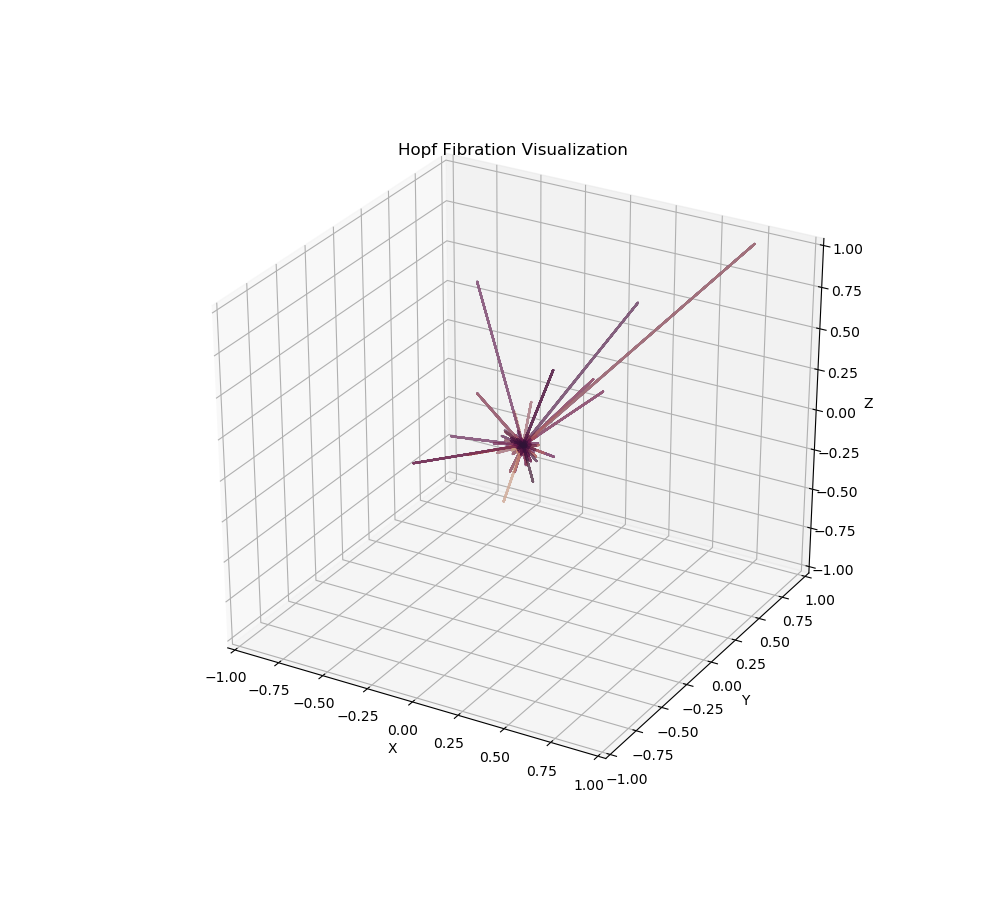

Total time to calculate 4D Coordinates & perform Stereographic Projection =  40.70197010040283  seconds
Total Time to generate =  40.94647669792175  seconds


In [14]:
start = time.time()
# Generate and visualise the Hopf fibration
visualise_hopf_fibration2()
elapsed_time = time.time() - start
print("Total Time to generate = ", elapsed_time, " seconds" )


## Discussion & Conclusions:

The **Generation of the Hopf Fibration using PYNQ with an AXI-Lite interface** presented a formidable challenge in the synthesis of complex mathematical visualisations through a hybrid of software and hardware computational strategies. The project aimed to parallelise the intensive computations of the Hopf Fibration generation by leveraging the PL section of an SoC, with the expectation that the PL's inherent parallel processing capabilities would ease the process.

### Hardware vs. Software:
Observations indicated that while the hardware implementation managed to execute the Hopf Fibration generation, it did not  outpace the software implementation. This was primarily due to the overhead associated with communication between the PL and the processing system. The computation on the FPGA, although fast, was bottlenecked by the data transmission via the AXI-Lite interface.

### Implementation Challenges:
One of the core limitations in the hardware implementation was the trigonometric precision required for the Hopf map calculations. These computations were constrained by the 32-bit representation, necessitating a difficult balance between range and precision.

### Visualisation Insights:
The visualisation, though successfully generated, revealed errors when compared with the software model. The trigonometric approach to rendering the Hopf Fibration, while conceptually sound, fell short in portraying the intricate fiber bundle connections, resulting in visual inconsistencies.

### Precision and Performance:
Precision was another stumbling block, as the fixed-point arithmetic utilised in the FPGA had to contend with the extensive range of values, from the minuscule to the exceedingly large. This limited precision resulted in a less accurate representation of the fibers.

### Future Directions:
Moving forward, enhancing the data transmission efficiency by implementing an AXI-Stream interface could potentially alleviate some of the current bottlenecks. Moreover, exploring alternative computational approaches could yield a more precise visualisation of the Hopf Fibration.

In conclusion, while the project did not achieve the anticipated acceleration in generating the Hopf Fibration, it highlighted the potential benefits and current limitations of FPGA applications in mathematical visualisation tasks. 


## Summary of Hopf Fibration Project

### Overview
This project, submitted for the University of Strathclyde's EE315 Further VHDL and FPGA Design course, explores the generation of the Hopf Fibration through both software and hardware implementations. The aim was to utilise the Programmable Logic (PL) section of a System on Chip (SoC) to accelerate computationally intensive parts of the Hopf Fibration generation, comparing its efficiency against purely software-based methods.

### What is Hopf Fibration?
The Hopf Fibration is a complex geometric structure mapping a 3-dimensional sphere (S^3) to a 2-dimensional sphere (S^2), discovered by Heinz Hopf in 1931. It is significant in topology and related fields due to its unique properties of linking every circle, or fiber, exactly once with every other circle, creating a fascinating intertwined structure.

### Implementation Details
- **Software Approach**: Utilizes Python with libraries such as NumPy and Matplotlib for calculations and 3D visualisations. The software approach involves calculating angles, converting these to 4D coordinates using the Hopf map, and then projecting these coordinates to 3D for visualisation.
- **Hardware Approach**: Leverages the AXI-Lite interface for FPGA-based computations, aiming to harness parallel processing capabilities of FPGAs. The design was implemented using Model Composer and Vivado, generating a bitstream for FPGA deployment.

### Performance Comparison
The hardware implementation was expected to perform faster by offloading intensive computations to the FPGA. However, the performance gains depend significantly on the efficiency of the FPGA design and the overhead of data transmission between the FPGA and the processing system. Ultimately, due to the trigonmetric nature the model was heavily limited and unable to accurately represent fibre bundles on the Hopf Fibration.

### Observations on Visualisation Outcomes

Despite the rigorous approach taken to model and visualize the Hopf Fibration, the results deviated from expected representations. The visualisation, intended to illustrate a seamless fibrous structure, resulted instead in a plot with apparent anomalies. This error can be accounted for by several factors:

- **Trigonometric Limitations**: The model relied heavily on trigonometric functions to map higher-dimensional data to a 3D space. Trigonometry can be demanding in terms of hardware, the model was revised multiple times in order to fit on the zynq chip. 

- **Sampling of Continuous Structures**: The sampling process, necessary for computational representation, can result in the loss of infinity that defines the elegance of the Hopf Fibration. 

- **Numerical Precision**: Computational limitations on numerical precision can lead to inaccuracies in representing very small or very large numbers, which are often encountered in calculations involving projections from higher dimensions.This was a partiuclar challenge due to the nature of all numbers needing to be represented within 32 bits, most numbers required more bits to be accurately represented.

- **Sampling Resolution**: The choice of sampling resolution for angles (alpha, phi, theta) directly affects the density and completeness of the fibers. Insufficient sampling can lead to gaps or the appearance of breaks in the continuity of the fibers.

### Result Analysis
The observed discrepancies underscore the challenges in accurately rendering complex mathematical objects like the Hopf Fibration. The model and visualisation methods must be carefully chosen and optimised to preserve the topological characteristics of the fibration. Future work may involve exploring alternative mathematical models and visualisation techniques, or increasing the resolution of the computation to minimise these issues.

---


### Conclusion
This project demonstrates the practical application of FPGAs in enhancing computational tasks in mathematical visualisations and provides a foundation for further exploration into more optimised hardware implementations.

---


